In [2]:
import tensorflow as tf
from tensorflow.keras.layers import (Dense, BatchNormalization, LeakyReLU, Reshape, Conv2DTranspose, Conv2D, Dropout, Flatten)
import matplotlib.pyplot as plt

In [3]:
(train_images, _), (_, _) = tf.keras.datasets.mnist.load_data()
train_images = (train_images - 127.5) / 127.5
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(60000).batch(256)

11490434/11490434 [==============================] - 2s 0us/step


In [6]:
def generator_model():
    model = tf.keras.Sequential()
    model.add(Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Reshape((7, 7, 256)))
    model.add(Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    print(model.summary())
    return model


In [7]:
generator = generator_model()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 12544)             1254400   
                                                                 
 batch_normalization_3 (Batc  (None, 12544)            50176     
 hNormalization)                                                 
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 12544)             0         
                                                                 
 reshape_1 (Reshape)         (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose_3 (Conv2DT  (None, 7, 7, 128)        819200    
 ranspose)                                                       
                                                                 
 batch_normalization_4 (Batc  (None, 7, 7, 128)       

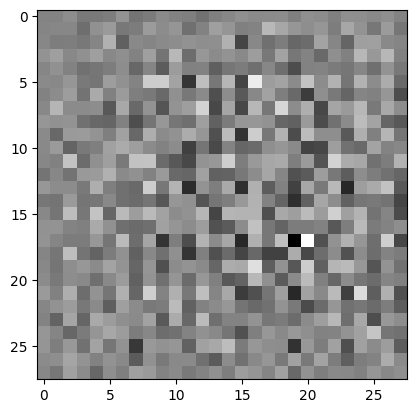

In [8]:
# Generate Sample Image
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')
plt.show()

In [9]:
def discriminator_model():
    model = tf.keras.Sequential()
    model.add(Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))
    model.add(LeakyReLU())
    model.add(Dropout(0.3))
    model.add(Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(LeakyReLU())
    model.add(Dropout(0.3))
    model.add(Flatten())
    model.add(Dense(1))
    print(model.summary())
    return model

In [10]:
discriminator = discriminator_model()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 64)        1664      
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 14, 14, 64)        0         
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 leaky_re_lu_7 (LeakyReLU)   (None, 7, 7, 128)         0         
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 128)         0         
                                                                 
 flatten (Flatten)           (None, 6272)             

In [11]:
# Configure the Model
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [12]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [13]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [14]:

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [15]:
@tf.function
def train_step(images):
    noise = tf.random.normal([images.shape[0], 100])
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [16]:
# Image Generation Function
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)
    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')

    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

In [18]:
# Train Model
def train(dataset, epochs):
    for epoch in range(epochs):
        for image_batch in dataset:
            train_step(image_batch)

        if (epoch + 1) % 5 == 0:
            generate_and_save_images(generator, epoch + 1, seed)

        print(f"Epoch {epoch + 1}/{epochs}")


    generate_and_save_images(generator, epochs, seed)

In [19]:
# Start Training
EPOCHS = 60
num_examples_to_generate = 16
noise_dim = 100
seed = tf.random.normal([num_examples_to_generate, noise_dim])

Epoch 1/60
Epoch 2/60
Epoch 3/60
Epoch 4/60


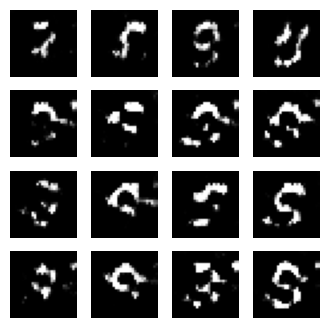

Epoch 5/60
Epoch 6/60
Epoch 7/60
Epoch 8/60
Epoch 9/60


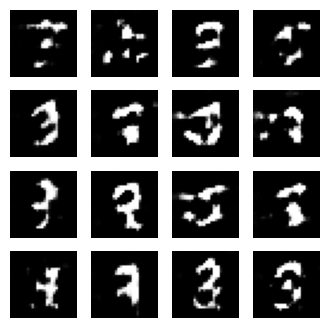

Epoch 10/60
Epoch 11/60
Epoch 12/60
Epoch 13/60
Epoch 14/60


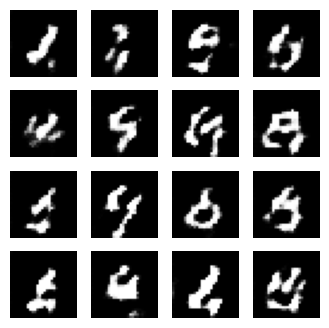

Epoch 15/60
Epoch 16/60
Epoch 17/60
Epoch 18/60
Epoch 19/60


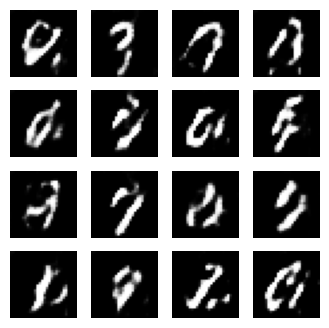

Epoch 20/60
Epoch 21/60
Epoch 22/60
Epoch 23/60
Epoch 24/60


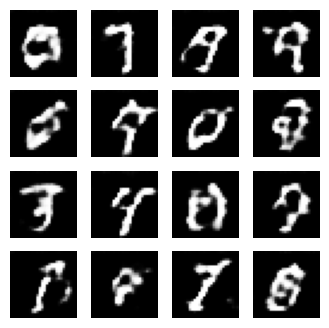

Epoch 25/60
Epoch 26/60
Epoch 27/60
Epoch 28/60
Epoch 29/60


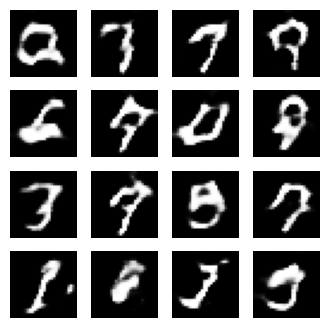

Epoch 30/60
Epoch 31/60
Epoch 32/60
Epoch 33/60
Epoch 34/60


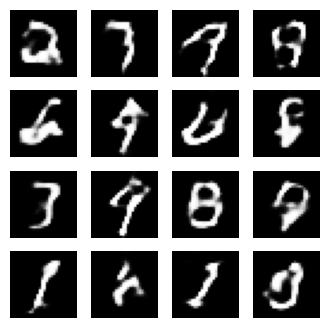

Epoch 35/60
Epoch 36/60
Epoch 37/60
Epoch 38/60
Epoch 39/60


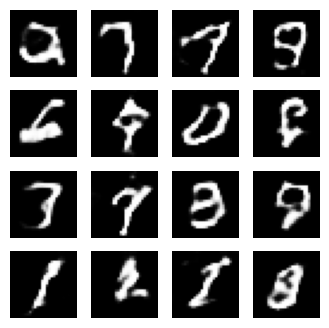

Epoch 40/60
Epoch 41/60
Epoch 42/60
Epoch 43/60
Epoch 44/60


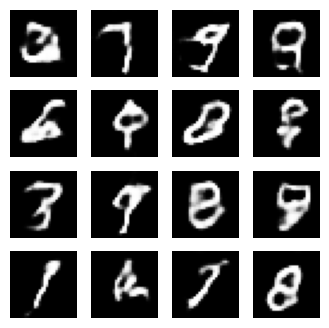

Epoch 45/60
Epoch 46/60
Epoch 47/60
Epoch 48/60
Epoch 49/60


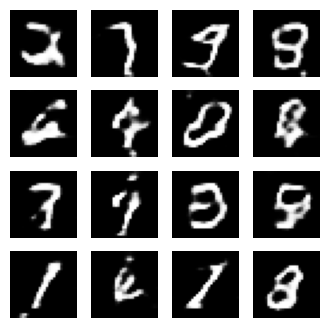

Epoch 50/60
Epoch 51/60
Epoch 52/60
Epoch 53/60
Epoch 54/60


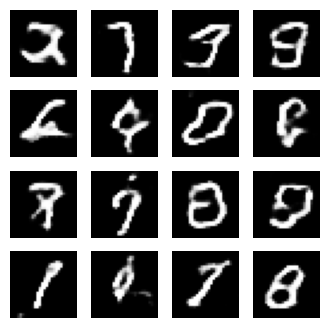

Epoch 55/60
Epoch 56/60
Epoch 57/60
Epoch 58/60
Epoch 59/60


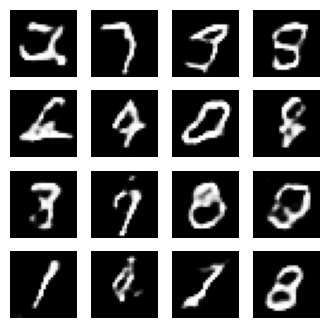

Epoch 60/60


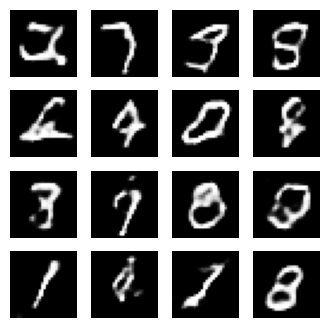

In [21]:
train(train_dataset, EPOCHS)